# Using the FAµST Factorization Wrappers

Previous notebooks already addressed a part of the [FaustFactory's](https://faustgrp.gitlabpages.inria.fr/faust/last-doc/html/classpyfaust_1_1FaustFactory.html) functionalities however this class is mainly dedicated to the FAµST's factorization algorithms of dense matrices into sparse transforms.
This is the subject covered (partly) in this notebook. 

You will see how to launch the algorithms easily or feed them with your own complex set of parameters, running them for only a few steps when possible, using a variant or another, enabling debug information, etc.

**NOTE**: the notebook is made to be executed sequentially, otherwise, skipping some cells, you would end up on an import error.


### Table of Contents

[**1. The Hierarchical PALM4MSA Algorithm**](#1.-The-Hierarchical-PALM4MSA-Algorithm)<br/>
[1.1 Generating an Hadamard Matrix](#1.1-Generating-an-Hadamard-Matrix)<br/>
[1.2 Factorizing an Hadamard Matrix](#1.2-Factorizing-an-Hadamard-Matrix)<br/>
[1.2.1 Defining the Constraints](#1.2.1-Defining-the-Constraints)<br/>
[1.2.2 Setting the Rest of the Parameters and Running the Algorithm](#1.2.2-Setting-the-Rest-of-the-Parameters-and-Running-the-Algorithm)<br/>

[**2. The FGFT Algorithms**](#2.-The-FGFT-Algorithms)<br/>
[2.1 The Givens / Jacobi Truncated Algorithms](#2.1-The-Givens-/-Jacobi-Truncated-Algorithms)<br/>
[2.2 The Hierarchical PALM4SMA based FGFT Algorithms](#2.2-The-Hierarchical-PALM4SMA-based-FGFT-Algorithms)<br/>

## 1. The Hierarchical PALM4MSA Algorithm

### 1.1 Generating a Hadamard Matrix

Before to tackle the Hadamard matrices factorization, let's introduce one of the FaustFactory method which is actually directly related: [FaustFactory.wht](https://faustgrp.gitlabpages.inria.fr/faust/last-doc/html/classpyfaust_1_1FaustFactory.html#a63efd7f7fd058b499a2edcf251361590).
This method allows you to generate sparse Hadamard transforms. 

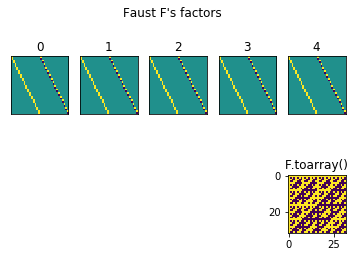

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pyfaust import FaustFactory as FF
from numpy.linalg import norm
from numpy.random import rand
# generate a Hadamard Faust of size 32x32
FH = FF.wht(5)
H = FH.toarray() # the dense matrix version
FH.imshow()
plt.show()

In [2]:
from numpy import count_nonzero
count_nonzero(H)

1024

All the factors are the same, let's print the first one.

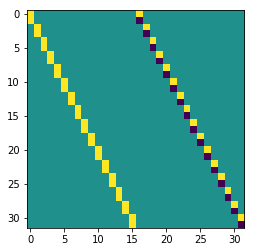

In [3]:
plt.imshow(FH.get_factor(0).toarray())
plt.show()

You might want to verify if $H$ is a proper Hadamard matrix.

In [4]:
from numpy import matrix, array
import numpy as np
is_hadamard = True
for _H in [H, H.T]:
    is_hadamard = is_hadamard and array([ (_H[i,:].dot(_H[j,:]) == 0).all() \
                                         for i in range(0, _H.shape[0]-1) \
                                         for j in range(i+1, _H.shape[0]) ]).all()
is_hadamard = is_hadamard and (np.where(abs(H)==1, H, 0) == H).all()
is_hadamard

True

The ugly code above basically verifies that all column or row vectors are mutually orthogonal and made only of -1, 0 and 1 coefficients, that is exactly the Hadamard matrix definition. The response is yes, so we can go ahead.

### 1.2 Factorizing an Hadamard Matrix

Let's begin by factorizing $H$ the easy way with the automatic parametrization provided by pyfaust.


Faust size 32x32, density 0.3125, nnz_sum 320, 5 factor(s): 
- FACTOR 0 (real) SPARSE, size 32x32, density 0.0625, nnz 64
- FACTOR 1 (real) SPARSE, size 32x32, density 0.0625, nnz 64
- FACTOR 2 (real) SPARSE, size 32x32, density 0.0625, nnz 64
- FACTOR 3 (real) SPARSE, size 32x32, density 0.0625, nnz 64
- FACTOR 4 (real) SPARSE, size 32x32, density 0.0625, nnz 64



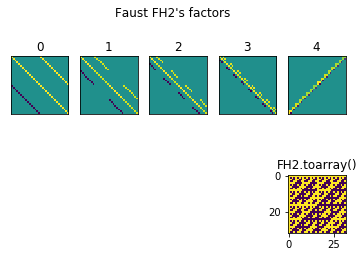

In [5]:
from pyfaust import faust_fact
FH2 = faust_fact(H, 'hadamard')
print(FH2)
FH2.imshow(name='FH2')

Interestingly, the FH2's factors are not the same as FH's but the resulting numpy array is exactly the same.
Just to be sure let's verify the relative error against H.

In [6]:
print('err=', (FH2-H).norm()/norm(H))

err= 1.10151525862e-16


This is good! Now to explain a little bit, the ```faust_fact```'s 2nd argument ```'hadamard'``` is a shorthand to designate a more complicated set of parameters fitting the Hadamard matrix factorization which was encoded into pyfaust like other configurations.

Speaking about shorthand, it's noteworthy that ```faust_fact``` is an alias of [FaustFactory.hierarchical_fact](file:///home/hinria/faust/build/doc/html/classpyfaust_1_1FaustFactory.html#ad4538456220163da26c32c1b956f1fe9).
Actually, this is quite clear now I think, but this function is implementing the hiearchical factorization which is PALM4MSA based. For details about the theory behind the algorithms you can read the Luc [Le Magoarou's thesis](https://tel.archives-ouvertes.fr/tel-01412558).

We won't go into details but nevertheless it's important to see how to define the parameters manually in order to proceed to your own customized factorizations. For that purpose we need to describe approximately the algorithm but please keep in mind this is just an insight (for instance, the norms below are voluntarily not defined).

Basically, the hierarchical algorithm works like this:

- If you want to decompose a matrix $M$ in $J$ factors, the algorithm will iterate $(J-1)$ times. Each iteration follow two steps:
- (the _local optimization_) At each iteration $i$ the currently considered matrix $R_{i-1}$ (with $R_0=M$) is decomposed in two factors by the PALM4MSA algorithm as respect to the minimization $\| R_{i-1} - S_{i}R_{i} \|$. <br/>$S_i$ is the resulting factor while $R_{i}$ is the _residuum_ of our factorization.
- (the _global optimization_) On the end of each iteration $i$, PALM4MSA is called again to compute the $argmin_{\{S_1, ..., S_i\}, R_i}$ $\|M - (\prod_{j=1}^i S_j) R_i\|$ 
- So ideally at the end of the iteration (J-1) you'll get something like $M \approx \prod_{i=1}^J S_i$ taking $S_J = R_{J-1} $.


### 1.2.1 Defining the Constraints

The explanation above is eluding something primary: the sparsity constraints. Indeed, the algorithm doesn't purpose to only decompose a matrix but it targets also to enhance its sparsity (like the FAµST acronym let's suppose ; Flexible Approximate Multi-layer Sparse Transform).

So you'll need to feed the algorithm with sparsity constraints (which correspond behind to proximal operators but it doesn't matter here). In fact, you'll define one pair of constraints per iteration, the first is for the factor $S_{i+1}$ and the second for $R_i$ (the _residuum_).

The pyfaust API is here to help you defining the constraints in one shot but you can if you want define constraints one by one as we'll see later.

Let's unveil the factorization constraints to decompose the Hadamard matrix $H \in \mathbb R^{n \times n}$. Generally in pyfaust, the constraints are defined in terms of norms, in our case of Hadamard factorization we'll use 0-norms:

- $ \forall i \in \{1,...,J-1\}, \|S_i\|_0 = 2n  \hspace{1cm} (C1) $
- $ \forall i \in \{1,...,J-1\}, \| R_i \|_0 = {n^2 \over 2^i}  \hspace{1cm} (C2)$

Enough of explanations! Let's go back to the code and define our constraints as lists (provided by the module ```pyfaust.factparams```):  


In [7]:
from pyfaust.factparams import ConstraintList
n = int(H.shape[0])
S_constraints = ConstraintList('splincol', 2, n, n,
                               'splincol', 2, n, n,
                               'splincol', 2, n, n,
                               'splincol', 2, n, n)
R_constraints = ConstraintList('splincol', int(n/2), n, n,
                               'splincol', int(n/4), n, n,
                               'splincol', int(n/8), n, n,
                               'splincol', int(n/16), n, n)

The 'splincol' constraint used here is for defining the maximum number of nonzeros elements to respect for any row or column of the considered matrix (here $S_i$ or $R_i$). 
Looking ```S_constraints``` initialization, we see in the first line ```'splincol', 2, n, n```. The value 2 means we impose 2 nonzeros per-column and per-row, the next arguments define the size of the matrix to constrain (its number of rows and columns). 

So in the example of ```S_constraints``` all the matrix will have a 0-norm equal to 2n, that is exactly what (C1) defined.<br/>
I let you decrypt why ```R_constraints``` correspond likewise to (C2).

But wait a minute, what would happen if we have a set of one hundred constraints? Don't worry! The pyfaust API allows to alternatively set the constraints one by one:


In [8]:
from pyfaust.factparams import ConstraintInt
S_constraints = [ConstraintInt('splincol', n, n, 2) for i in range(0,4)]
R_constraints = [ConstraintInt('splincol', n, n, int(n/2**i)) for i in range(1,5)]

```S_constraints``` and ```R_constraints``` are still the exact same set of constraints as before.

[ConstraintInt](https://faustgrp.gitlabpages.inria.fr/faust/last-doc/html/classpyfaust_1_1factparams_1_1ConstraintInt.html) is a family of integer constraints. More globally, there is a hierarchy of classes whose parent class is [ConstraintGeneric](https://faustgrp.gitlabpages.inria.fr/faust/last-doc/html/classpyfaust_1_1factparams_1_1ConstraintGeneric.html) where you'll find other kind of constraints ; [ConstraintMat](https://faustgrp.gitlabpages.inria.fr/faust/last-doc/html/classpyfaust_1_1factparams_1_1ConstraintMat.html), [ConstraintReal](https://faustgrp.gitlabpages.inria.fr/faust/last-doc/html/classpyfaust_1_1factparams_1_1ConstraintReal.html).

The table [here](https://faustgrp.gitlabpages.inria.fr/faust/last-doc/html/constraint.png) can give you an idea of each constraint definition. As evoked above a constraint is associated to a proximal operator which projects the matrix into the set of matrices defined by the constraint or at least it tries to (because it's not necessarily possible).

In the last versions of FAµST it's possible to ```project``` matrices from the wrappers themselves, let's try one ConstraintInt:

In [9]:

A = rand(10,10)
A_ = ConstraintInt('sp', 10, 10, 18).project(A)
print("A nnz:", count_nonzero(A), "A_ nnz:", count_nonzero(A_))

A nnz: 100 A_ nnz: 18


We asked of a sparsity of 18 nonzeros elements and that's what we got after calling ```project```.

The function ```project``` can help you debugging a factorization or even understand exactly how a _prox_ works for a specific constraint and matrix.

Another API doc link completes the definition of constraints : [ConstraintName](https://faustgrp.gitlabpages.inria.fr/faust/last-doc/html/classpyfaust_1_1factparams_1_1ConstraintName.html)



### 1.2.2 Setting the Rest of the Parameters and Running the Algorithm

OK, let's continue defining the algorithm parameters, the constraints are the most part of it. You have optional parameters too, but one key parameter is the stopping criterion of the PALM4MSA algorithm.
You have to define two stopping criteria, one for the _local optimization_ and another for the _global optimization_.

In [10]:
from pyfaust.factparams import StoppingCriterion
loc_stop = StoppingCriterion(num_its=30)
glob_stop = StoppingCriterion(num_its=30)

The type of stopping criterion used here is the number of iterations of PALM4MSA, that is the number of times all the current factors ($R_i$ included) are updated either for the local or the global optimization. So, regarded the initialization of ```loc_stop``` and ```glob_stop``` above, if you asked J factors (through the number of constraints you set) you'd count a total of $(30+30)*(J-1)$ iterations of PALM4MSA. 

Ok, I think we're done with the algorithm parameters, we can pack our them into one object and give it to ```faust_fact```.


In [11]:
from pyfaust.factparams import ParamsHierarchicalFact
params = ParamsHierarchicalFact(S_constraints, R_constraints, loc_stop, glob_stop,
                                is_update_way_R2L=True) # the argument order matters!
# launch the factorization
FH3 = faust_fact(H, params)
FH3

Faust size 32x32, density 0.3125, nnz_sum 320, 5 factor(s): 
- FACTOR 0 (real) SPARSE, size 32x32, density 0.0625, nnz 64
- FACTOR 1 (real) SPARSE, size 32x32, density 0.0625, nnz 64
- FACTOR 2 (real) SPARSE, size 32x32, density 0.0625, nnz 64
- FACTOR 3 (real) SPARSE, size 32x32, density 0.0625, nnz 64
- FACTOR 4 (real) SPARSE, size 32x32, density 0.0625, nnz 64

You might wonder what is the boolean ```is_update_way_R2L```. Its role is to define if the PALM4MSA algorithm will update the $S_i$ and last $R_i$ factors from the left to right (if ```False```) or toward the opposite direction (if ```True```). It does change the results of factorization!

I must mention that there are several other optional arguments you'd want to play with for configuring, just dive the [documentation](https://faustgrp.gitlabpages.inria.fr/faust/last-doc/html).

You also might call the PALM4MSA algorithm directly (not the hierarchical algorithm whichs make use of it), the function is [here](https://faustgrp.gitlabpages.inria.fr/faust/last-doc/html/classpyfaust_1_1FaustFactory.html#ab21d4f590515e18250687e67acc58f23). You can theoretically reproduce the hierarchical algorithm step by step calling ```fact_palm4msa()``` by yourself.

Well, there would be a lot to say and show about these two pyfaust algorithms and their parameters but at least with this example, I hope, you got here an insight of how it works.

## 2. The FGFT Algorithms

Since the version 2.4 FAµST is able to compute Fast Graph Fourier Transforms.
FAµST includes two algorithms in this goal:
- the first one is a variant of the hierarchical algorithm discussed in chapter 1.
- The second one is a truncated version of the eigenvalue decomposition Jacobi algorithm.

The two of them are implemented in C++ and Python wrappers make them available from pyfaust.

Here again the theory isn't what matters but feel free to take a look to the following papers:

- Le Magoarou L., Gribonval R., Tremblay N., [“Approximate fast graph Fourier transforms via multi-layer sparse approximation“,Transactions on Signal and Information Processing over Networks](https://hal.inria.fr/hal-01416110)

- Le Magoarou L. and Gribonval R., ["Are there approximate Fast Fourier Transforms on graphs ?", ICASSP, 2016](https://hal.inria.fr/hal-01254108)


### 2.0 The pygsp Toolbox

Since we're going to work with graph Laplacians it would be a pity not to plot things. The pygsp toolbox (you can install through pip or conda) provides what you need to easily obtain Laplacians of different graph families. Please install the package with pip (or maybe conda).

Let's plot a Erdös Renyi graph (on the right) and its associated Laplacian matrix (on the left).


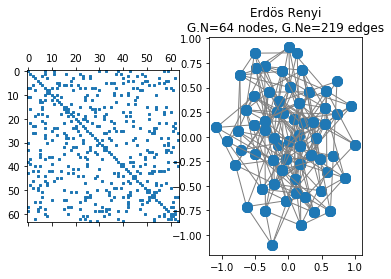

In [12]:
from pygsp.graphs import erdosrenyi
import matplotlib.pyplot as plt
G = erdosrenyi.ErdosRenyi(N=64, seed=42)
G.set_coordinates(kind='spring', seed=42)
fig, axes = plt.subplots(1, 2)
_ = axes[0].spy(G.L, markersize=2)
_ = G.plot(ax=axes[1])
plt.show()

The goal of our FGFT algorithms is basically to produce an approximate sparse transform of the fourier basis (i.e. the eigenvectors) and the diagonal matrix of the corresponding eigenvalues.
If $L$ is the Laplacian matrix, $\hat U$ the fourier sparse transform and $\hat D$ the diagonal factor, we'll have this kind of approximation: $ L \approx \hat U \hat D \hat U ^ T$

### 2.1 The Givens / Jacobi Truncated Algorithms

Let's run the first algorithm on our Laplacian example. You'll see it's really straightforward!

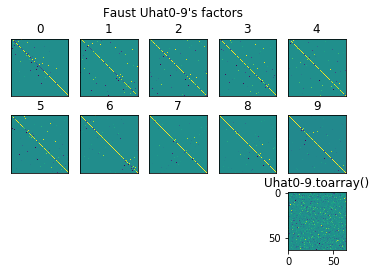

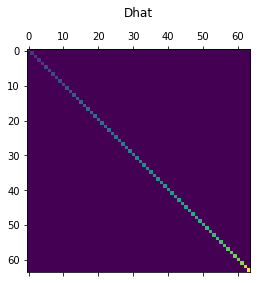

In [13]:
import matplotlib.pyplot as plt
from pyfaust import FaustFactory as FF
L = G.L.toarray()
Uhat, Dhat = FF.eigtj(L, J=L.shape[0]*5, t=int(L.shape[0]/2))
Uhat.get_factor(range(0,min(10,Uhat.get_num_factors()))).imshow(name='Uhat0-9')
_a = plt.matshow(Dhat.toarray())
title = _a.axes.set_title('Dhat\n')
plt.show()

For the sake of visibility I displayed only the first nine factors of $\hat U$, as you can see they are sparse and $\hat D$ is a diagonal matrix.

Write some code to check the first factor $\hat U $ is orthogonal and then that $\hat U$ itself is orthogonal.

In [14]:
from numpy import eye
Uhat0 = Uhat.get_factor(0)
((Uhat0*Uhat0.T).toarray() == eye(*Uhat0.shape)).all()

True

In [15]:
norm((Uhat*Uhat.T).toarray()-eye(*Uhat.shape))

2.3697882514690342e-15

Ignoring the fact that $\hat U$ is approximate and maybe some slight numerical error, yes it is orthogonal.

In [16]:
norm(Uhat*Dhat.toarray()*Uhat.T.todense()-L)/norm(L)

0.19425511813844365

Good! The Laplacian approximation defined by $\hat U$ and $\hat D$ seems not so bad because according to the relative error. Do you want a smaller error ? It's time to read the [documentation](https://faustgrp.gitlabpages.inria.fr/faust/last-doc/html/classpyfaust_1_1FaustFactory.html#a14b07bcd09f4e929aefd28e17d62c866), the ```eigtj()```'s keyword argument ```J``` can help you in that.

Is that all? No, we can evaluate the memory saving $\hat U$ brings relatively to U obtained by ```numpy.linalg.eig()```. By the way, maybe you didn't noticed but $\hat U$ (or ```Uhat``` in the code) is a Faust!

In [17]:
from numpy.linalg import eig
from numpy import diag, count_nonzero
D, U = eig(L)
D = diag(D)
print(norm(U@D@U.T-L)/norm(L))

1.77080628112e-14


In [18]:
Uhat.nnz_sum()

1246

In [19]:
count_nonzero(U)

4096

The memory space to store $\hat U$ is smaller since its number of nonzeros elements is less than U's.

### 2.2 The Hierarchical PALM4SMA based FGFT Algorithms

To finish this notebook briefly, we won't go in further details about the second algorithm for computing approximate FGFTs because it's based on the algorithms discussed in [1](http://127.0.0.1:8890/notebooks/gen_doc/Faust_factorization.ipynb#1.-The-Hierarchical-PALM4MSA-Algorithm).

However, you'll find below a copy of the main example of [fgft_palm()](https://faustgrp.gitlabpages.inria.fr/faust/last-doc/html/classpyfaust_1_1FaustFactory.html#a687ab9cbf9e82f9f945771447b3f00a2). This function is the entry of the algorithm and again it's very similar to what you've seen above.
You can try to unroll it progressively and understand how it tries to do the same thing than the eigtj() on another Laplacian matrix.
It's much more complicated to configure but starting from an example you'll be able to write your own FGFT calculation.

Abouth the Laplacian matrix used in the code, note that pyfaust embeds some data (matrices in matlab v7 format) but depending on how you installed the package you maybe need to download them. It's not a big deal normally because ```get_data_dirpath()``` should handle it automatically (otherwise please read the [help doc](https://faustgrp.gitlabpages.inria.fr/faust/last-doc/html/FAQ.html)).


In [20]:
from pyfaust import FaustFactory
from pyfaust.factparams import *
from pyfaust.demo import get_data_dirpath
from os.path import sep
from scipy.io import loadmat, savemat
from numpy.linalg import eig, eigh, norm
from numpy import sort, argsort, log2, size, copy, diag
d = loadmat(sep.join((get_data_dirpath(),'Laplacian_128_ring.mat')))
Lap = d['Lap']
D, U = eig(Lap)
indices = argsort(D)
D = D[indices]
U = U[:,indices]
print(D.shape, type(D))
print("eig(Lap), U error:", norm(Lap.dot(U)-U.dot(diag(D))))
dim = Lap.shape[0]
nfacts = int(round(log2(dim))-3)
over_sp = 1.5 # sparsity overhead
dec_fact = .5 # decrease of the residum sparsity
fact_cons, res_cons = [], []
for j in range(1, nfacts):
        fact_cons += [ ConstraintInt('sp',dim,dim,
        min(int(round(dec_fact**j*dim**2*over_sp)),size(Lap)))
    ]
        res_cons += [
                ConstraintInt('sp',
            dim,
            dim,
            min(int(round(2*dim*over_sp)),size(Lap)))
        ]
params = ParamsHierarchicalFact(fact_cons,
        res_cons,
        StoppingCriterion(num_its=50),
        StoppingCriterion(num_its=100),
        step_size=1.0000e-06,
        constant_step_size=True,
        init_lambda=1.0,
        is_fact_side_left=False)
Lap = Lap.astype(float)
Uhat,Dhat = FaustFactory.fgft_palm(Lap, U, params, init_D=D)
err_U = (Uhat-U).norm()/norm(U)
err_Lap = norm(Uhat.todense()*diag(Dhat)*Uhat.T.todense()-Lap)/norm(Lap)
print(norm(diag(Dhat), 2))
print("err_U:", err_U)

(128,) <class 'numpy.ndarray'>
eig(Lap), U error: 1.36688422173e-13
4.00000005215
err_U: 1.00138959974


------------------------------

***The third notebook is ending here***, I hope you'll be interesting to dig into pyfaust API and maybe even give some feedback later. The API has made a lot of progress lastly but it remains a work-in-progress and some bugs might appear here or there. Besides, the documentation and the API can always receive some enhancement so don't hesitate, any suggestion is welcome!